In [1]:
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

import dill
import seaborn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def MalhaRetangular(N):
   Δ = 1.0/N
   Δx = Δ; Δy = Δ
   x = API_Numpy.arange(0.0,0.25+Δx,Δx)
   y = API_Numpy.arange(Δy,1.0,Δy)

   X = API_Numpy.stack([x]*y.shape[0],axis=1)
   Y = API_Numpy.stack([y]*x.shape[0],axis=0)

   return X, Y, Δ

In [4]:
def CondiçãoInicialRayleighTaylor(X, Y, γ):
   R = API_Numpy.zeros(X.shape)
   P = API_Numpy.zeros(X.shape)
   U = API_Numpy.zeros(X.shape)
   V = API_Numpy.zeros(X.shape)
   for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      if Y[i,j] < 0.5:
         R[i,j] = 2.0
         P[i,j] = 2.0*Y[i,j] + 1.0
      else:
         R[i,j] = 1.0
         P[i,j] = Y[i,j] + 1.5
         
      a = API_Numpy.sqrt(γ * P[i,j] / R[i,j])
      V[i,j] = -0.025 * a * API_Numpy.cos(8.0*API_Numpy.pi*X[i,j])

   E = P/(γ-1.0) + R*(U**2 + V**2)/2.0
   Q0 = API_Numpy.stack([R, R*U, R*V, E],axis=0)
   n=X.shape[0]//2
   Q0[:,-n:,:]=API_Numpy.reverse(Q0[:,:n,:].copy(),axis=1)
   return Q0


def CondiçãoInicialRayleighTaylor_N(N, γ):
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialRayleighTaylor(X, Y, γ)
   return X, Y, Δ, Q0

In [6]:
def RayleighTaylorGhostPointsX(Q,API):
    left=API.stack([Q[...,0,:3,:],-Q[...,1,:3,:],Q[...,2,:3,:],Q[...,3,:3,:]],axis=-3)
    left=API.reverse(left,axis=[-2])

    center=Q

    right=API.stack([Q[...,0,-3:,:],-Q[...,1,-3:,:],Q[...,2,-3:,:],Q[...,3,-3:,:]],axis=-3)
    right=API.reverse(right,axis=[-2])

    return API.concat([left,center,right],axis=-2)

def RayleighTaylorGhostPointsY(Q,API):
   raw_ref_shape=API.shape(Q)[:-3]
   out_shape=API.concat([API.shape(Q)[:-1],[3]],axis=0)
   ref_shape=API.concat([API.ones(API.shape(raw_ref_shape),dtype='int32'),[4],[1],[1]],axis=0)
   vals_left=API.reshape([2.0,0.0,0.0,1.0/(γ-1.0)],ref_shape)
   vals_right=API.reshape([1.0,0.0,0.0,2.5/(γ-1.0)],ref_shape)
   Qg = [API.ones(out_shape,'float64')*API.cast(vals_left,'float64'),
         Q,
        API.ones(out_shape,'float64')*API.cast(vals_right,'float64')]
   return API.concat(Qg,-1)

In [7]:
API=API_Numpy

WENO_Z_sim=lambda ε:simulation_2D(API,
                        euler_equation_2D,
                        WENO_Z,
                        ε=ε)

WENO_Zp_sim=lambda ε:simulation_2D(API,
                        euler_equation_2D,
                        WENO_Z_plus,
                        ε=ε)

WENO_Z_MS_sim=lambda ε:simulation_2D(API,
                        euler_equation_2D,
                        WENO_Z,
                        map_function=Hong_mapping,
                        mapping=pre_mapping,
                        ε=ε)

WENO_Zp_MS_sim=lambda ε:simulation_2D(API,
                        euler_equation_2D,
                        WENO_Z_plus,
                        map_function=Hong_mapping,
                        mapping=pre_mapping,
                        ε=ε)

WENO_Z_BI_sim=lambda ε:simulation_2D(API,
                        euler_equation_2D,
                        WENO_Z,
                        map_function=BI_mapping,
                        mapping=pre_mapping,
                        ε=ε)

WENO_ZC_MS_sim=lambda ε:simulation_2D(API,
                        euler_equation_2D,
                        WENO_Z_pm,
                        map_function=Hong_mapping,
                        mapping=pre_inv_mapping,
                        ε=ε)

WENO_ZC_BI_sim=lambda ε:simulation_2D(API,
                        euler_equation_2D,
                        WENO_Z_pm,
                        map_function=BI_mapping,
                        mapping=pre_inv_mapping,
                        ε=ε)

In [8]:
γ = 5.0/3.0
x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(100, γ)

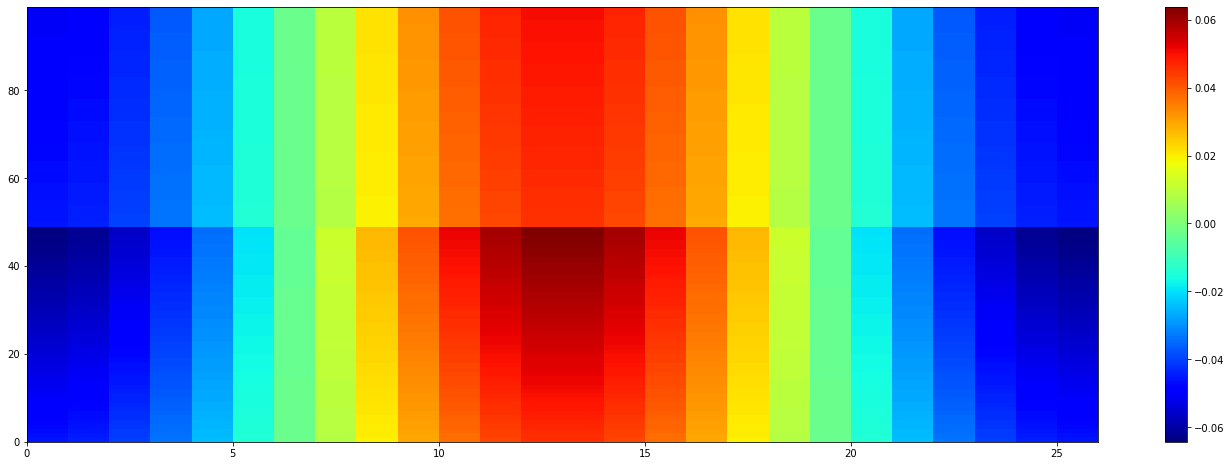

In [9]:
    plt.figure(figsize=(3*8,8))
    count=5
    ref_U=U0[2]
    a=plt.pcolormesh(ref_U.T,cmap='jet')
    plt.colorbar(a)

In [16]:
for WENO_type,name in zip([
    WENO_Z_sim,
    WENO_Z_BI_sim,
    WENO_Z_MS_sim,
    WENO_Zp_sim,
    WENO_Zp_MS_sim,
    WENO_ZC_MS_sim,
    WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    'WENO-Z (BI)',
    'WENO-Z (MS)',
    'WENO-Z+',
    'WENO-Z+ (MS)',
    'WENO-ZC (MS)',
    'WENO-ZC (BI)'
    ]):
    for ε in (1e-40,):
            WENO=WENO_type(ε)

            for N in (480,):
                U_final=[]
                γ = 5.0/3.0
                x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)
                cfl = 0.3
                t_final = 1.95

                U=U0.copy()
                U_final.append(U.copy())
                t=0
                count=0

                if not(os.path.isdir(f'imagens/RT{N}-CFL{str(cfl).replace(".","_")}-{name}-epsilon={np.log10(ε)}-numpy/')):
                        os.mkdir(f'imagens/RT{N}-CFL{str(cfl).replace(".","_")}-{name}-epsilon={np.log10(ε)}-numpy/')

                Δt_step=0.01
                while t<t_final:
                    t_step=0
                    
                    while t_step<Δt_step:
                        Λ  = WENO.equation.maximum_speed(U)
                        Δt = Δ*cfl/Λ
                        Δt = np.where(t_step+Δt>Δt_step,Δt_step-t_step,Δt)

                        U=WENO.Sim_step(U, Δt, Δ, Δ, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY,RayleighTaylorGravity)
                        t_step+=Δt

                    count+=1
                    t+=Δt_step
                    print(t,end='\r')
                    U_final.append(U[...])
                    plt.figure(figsize=(10,16))
                    ref_U=U[0].copy()

                    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.9,vmax=2.3)
                    plt.colorbar(a)
                    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.9,vmax=2.3,colors='black',linewidths=0.5)

                    plt.ylim(ymin=0.2,ymax=0.8)
                    plt.title(name)
                    plt.savefig(f'imagens/RT{N}-CFL{str(cfl).replace(".","_")}-{name}-epsilon={np.log10(ε)}-numpy/{str(count).zfill(3)}.png')
                    plt.close()
                
                    with open(f'imagens/RT{N}-CFL{str(cfl).replace(".","_")}-{name}-epsilon={np.log10(ε)}-numpy/data.bkp','wb') as file:
                        dill.dump(np.stack(U_final,0),file)

In [13]:
str(cfl).replace('.','_')

'0_3'

In [ ]:
for name in [
    'WENO-Z',
    # 'WENO-Z+',
    # 'WENO-Z (BI)',
    # 'WENO-Z (MS)',
    # 'WENO-Z+ (MS)',
    # 'WENO-ZC (MS)',
    # 'WENO-ZC (BI)'
    ]:

    for N in (800,):
        γ = 5.0/3.0
        x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)

        if not(os.path.isdir(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/')):
                os.mkdir(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/')
        
        with open(f'imagens/RT{N}-CFL02-{name}-epsilon={np.log10(ɛ)}/data.bkp','rb') as file:
            U=dill.load(file)[:,0]

        errors=U.copy()
        
        errors=np.abs(errors-API_Numpy.reverse(errors,axis=1))

        vmax=np.max(errors)
        vmin=0

        for count,Ui in enumerate(errors):
            print(count,end='\r')
            plt.figure(figsize=(10,16))
            ref_U=Ui

            a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=vmin,vmax=vmax)
            plt.colorbar(a)
            plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=vmin,vmax=vmax,colors='black',linewidths=0.5)

            plt.ylim(ymin=0.2,ymax=0.8)
            plt.title(name)
            plt.savefig(f'imagens/RT{N}-diff-CFL02-{name}-epsilon={np.log10(ɛ)}/{str(count+1).zfill(3)}.png')
            plt.close()

<ipython-input-14-8ebd724dff24>:36: UserWarning: No contour levels were found within the data range.
  plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=vmin,vmax=vmax,colors='black',linewidths=0.5)


In [35]:
γ = 5.0/3.0
N = 400
x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)
cfl = 0.6
t_final = 0.1

In [36]:
WENO_Z_sim=simulation_2D(API_TensorFlow,
                        euler_equation_2D,
                        WENO_Z,
                        ε=1e-40)

In [37]:
t=0
count=0
U=U0.copy()
while t<t_final:
    Λ  = WENO_Z_sim.equation.maximum_speed(U)
    Δt = Δ*cfl/Λ
    Δt = np.where(t+Δt>t_final,t_final-t,Δt)

    U=WENO_Z_sim.Sim_step(U, Δt, Δ, Δ, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY, RayleighTaylorGravity)
    t+=Δt
    print(t,end='\r')

In [50]:
import h5py

f = h5py.File("data_test_julia.jld", "r")
data_julia=np.asarray(f['data']).transpose((0,2,1))

2.822408973202073e-12


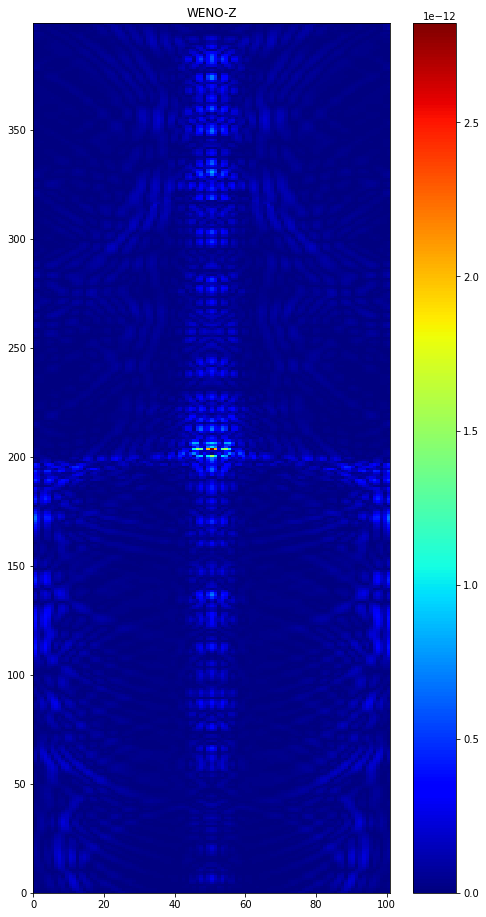

In [56]:
plt.figure(figsize=(8,16))
ref_U=np.abs(U[0]-data_julia[0])
print(np.max(ref_U))
a=plt.pcolormesh(ref_U.T,cmap='jet')
plt.colorbar(a)
plt.title('WENO-Z')
plt.show()